# Hybrid Control - Worksheet 6 - Final Project

### Group - Henrique Gundlach Lacerda and Lara Polachini

# Question 6

In [11]:
#!/usr/bin/python3
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as pt
import control as ct
from control.matlab import *

In [12]:
# Helpers %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def edInt(a,s,b):
    return np.linspace(a,b,int(np.floor((b-a)/s)))

# Used for poorman's nearest-neighbour regular-grid interpolation
def idx(aList, val):
    i = bi.bisect(aList, val) # right
    if i <= 0: # first
        pass
    elif len(aList) == i: # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val: # left
        i -= 1
    return i

def lookup(aList, vals):
    """result is undefined if vals is not sorted"""
    indices = []
    v = vals
    if type(v) in [int,float,np.int64,np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList,k))
    return np.array(indices, dtype=np.uint32)

In [13]:
# Settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
dt = 0.5; infStValInc = 500; nullCtr = 0
T = edInt(0, dt, 80)
du = 1
U = edInt(-50, du, 10)  # admissible controls (heater power)

# IMPORTANT: DP grid is on ERROR e = z - w  (must include negatives!)
x1, x2 = np.meshgrid(edInt(-150, 5, 150), edInt(-150, 5, 150))  # admissible ERROR states

a1 = a2 = .01
b1 = b2 = .005
A = np.array([[-a1, b1], [b2, -a2]])
B1 = np.array([1.0, 0.0])  # heater 1 affects z1
B2 = np.array([0.0, 1.0])  # heater 2 affects z2

# System constants
Q = np.array([[150.0, 0.0], [0.0, 150.0]])
R = 0.1
z0 = np.array([15.0, 0.0])             # initial absolute state (only for simulation)

w_seq = np.array([
    [80.0, 100.0],   # w(0)
    [60.0,  90.0],   # w(1)
    [90.0, 110.0],   # w(2)
])
T_sw = w_seq.shape[0]

N = T.size

V = np.zeros((x2.shape[0], x1.shape[1], N))  # optimal cost (for heater 1 mode)
u_opt = V.copy()                              # optimal control (heater 1 mode)
V[:, :, N-1] = Q[0,0] * x1**2 + Q[1,1] * x2**2  # terminal penalties on ERROR (goal error = 0)

err_x1 = np.zeros((x2.shape[0], x1.shape[1]))
err_x2 = err_x1.copy()
depth = 0  # for value snapshots

# -------- (b) second controller (mode ℓ2): duplicate data structures --------
V2 = np.zeros_like(V)
V2[:, :, N-1] = Q[0,0] * x1**2 + Q[1,1] * x2**2
u_opt2 = np.zeros_like(u_opt)

In [14]:
def compute_dp_tables(w):
    # Algorithm (operating on isolated equilibrium) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # DP is performed on ERROR state e. Plant dynamics are on absolute z:
    #   z_dot = A z + B u
    # with z = e + w  =>  e_dot = A(e + w) + B u
    # allocate NEW arrays for each w
    V  = np.zeros((x2.shape[0], x1.shape[1], N))
    V2 = np.zeros_like(V)
    u_opt  = np.zeros_like(V)
    u_opt2 = np.zeros_like(V)

    V[:, :, N-1]  = Q[0,0] * x1**2 + Q[1,1] * x2**2
    V2[:, :, N-1] = Q[0,0] * x1**2 + Q[1,1] * x2**2

    for k in range(N-1, depth, -1):
        for i in range(0, x2.shape[0]):
            for j in range(0, x1.shape[1]):

                # current ERROR state
                e = np.array([x1[i, j], x2[i, j]])

                # stage cost for all candidate controls (vectorised over U)
                L = dt * (e.T @ Q @ e + R * U**2)

                # absolute state corresponding to this error
                z = e + w
                z_dot = A @ z

                # ---------- Mode ℓ1 (heater 1 affects z1) ----------
                new_e1 = e[0] + (z_dot[0] + B1[0] * U) * dt
                new_e2 = e[1] + (z_dot[1] + B1[1] * U) * dt

                i_new_x1 = lookup(x1[0, :], new_e1)  # naive interpolation
                i_new_x2 = lookup(x2[:, 0], new_e2)
                i_U = range(0, U.size)

                err_x1[i, j] = np.max(new_e1)  # diagnostics
                err_x2[i, j] = np.max(new_e2)

                # ---------- Mode ℓ2 (heater 2 affects z2) ----------
                new_e1_2 = e[0] + (z_dot[0] + B2[0] * U) * dt
                new_e2_2 = e[1] + (z_dot[1] + B2[1] * U) * dt

                i_new_x1_2 = lookup(x1[0, :], new_e1_2)
                i_new_x2_2 = lookup(x2[:, 0], new_e2_2)
                i_U_2 = range(0, U.size)

                # --- DP backup for mode ℓ1 ---
                if (i_new_x1.size != 0 and i_new_x2.size != 0):
                    i_U, V[i, j, k-1] = min(
                        enumerate(L[i_U] + V[i_new_x2, i_new_x1, k]),
                        key=lambda x: x[1]
                    )
                else:
                    i_U, V[i, j, k-1] = lookup(U, nullCtr)[0][0], V[i, j, k] + infStValInc

                # --- DP backup for mode ℓ2 ---
                if (i_new_x1_2.size != 0 and i_new_x2_2.size != 0):
                    i_U_2, V2[i, j, k-1] = min(
                        enumerate(L[i_U_2] + V2[i_new_x2_2, i_new_x1_2, k]),
                        key=lambda x: x[1]
                    )
                else:
                    i_U_2, V2[i, j, k-1] = lookup(U, nullCtr)[0][0], V2[i, j, k] + infStValInc

                u_opt[i, j, k-1]  = U[i_U]    # i_U is the argmin index (scalar)
                u_opt2[i, j, k-1] = U[i_U_2]

    return u_opt, u_opt2, V, V2


C:\Users\larap\AppData\Local\Temp\ipykernel_19080\3840757863.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(Vtab[i2, i1, 0])
C:\Users\larap\AppData\Local\Temp\ipykernel_19080\3840757863.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = z + (A @ z + np.array([float(u1), 0.0])) * dt
C:\Users\larap\AppData\Local\Temp\ipykernel_19080\3840757863.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = z + (A @ z + np.array([0.0, float(u2)])) * 

N* between stage 0 and 1 = 52   J* = 120357892.85550146


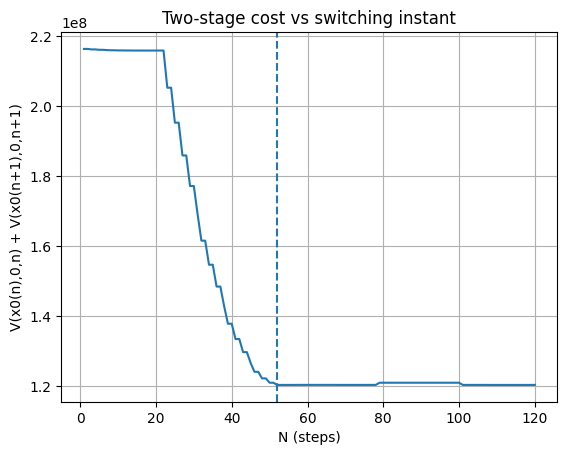

In [15]:
tables = []
for sw in range(T_sw):
    u1tab, u2tab, V1, V2 = compute_dp_tables(w_seq[sw])
    tables.append((u1tab, u2tab, V1, V2))

# (c) hybrid switching parameters (guards with tolerance)
state = 0          # 0=off, 1=heater1 (ℓ1), 2=heater2 (ℓ2)
t1 = 10
t2 = 10
alpha = 0.8
sw = 0
w_cur = w_seq[sw]

def V_at_state(Vtab, z_abs, w_ref):
    e = z_abs - w_ref
    i2 = lookup(x2[:, 0], e[1])
    i1 = lookup(x1[0, :], e[0])
    return float(Vtab[i2, i1, 0])

def simulate_fixed_reference(z_start, w_ref, u_opt_ref, u_opt2_ref, Nsteps):
    z = z_start.copy()
    state = 0  # start with heater off like your HA

    for k in range(Nsteps):
        e = z - w_ref

        if state == 0:
            z = z + (A @ z) * dt
            if z[0] <= alpha * w_ref[0]:
                state = 1
            elif z[1] <= alpha * w_ref[1]:
                state = 2

        elif state == 1:
            u1 = u_opt_ref[lookup(x2[:, 0], e[1]), lookup(x1[0, :], e[0]), k]
            z = z + (A @ z + np.array([float(u1), 0.0])) * dt
            if z[0] >= w_ref[0] - t1:
                state = 0

        elif state == 2:
            u2 = u_opt2_ref[lookup(x2[:, 0], e[1]), lookup(x1[0, :], e[0]), k]
            z = z + (A @ z + np.array([0.0, float(u2)])) * dt
            if z[1] >= w_ref[1] - t2:
                state = 0

    return z

def compute_N_star(n, x0n, Nmax=None):
    """
    n: stage index (0..T_sw-2)
    x0n: absolute initial state for stage n (e.g. z0)
    """
    if Nmax is None:
        Nmax = min(200, N-1)  # safe default

    w_n   = w_seq[n]
    w_np1 = w_seq[n+1]

    u1n, u2n, Vn,  V2n  = tables[n]
    u1p, u2p, Vp,  V2p  = tables[n+1]

    # stage-1 value from x0(n) with reference w(n)
    V1 = V_at_state(Vn, x0n, w_n)

    bestN = 1
    bestJ = np.inf
    J_list = []

    for Nh in range(1, Nmax+1):
        # x0(n+1) is the state reached after Nh steps with stage-n controller & reference
        x0_np1 = simulate_fixed_reference(x0n, w_n, u1n, u2n, Nh)

        # stage-2 value from x0(n+1) with reference w(n+1)
        V2 = V_at_state(Vp, x0_np1, w_np1)

        J = V1 + V2
        J_list.append(J)

        if J < bestJ:
            bestJ = J
            bestN = Nh

    return bestN, bestJ, np.array(J_list)


n = 0  # compute split between w(0) and w(1)
N_star, J_star, J_curve = compute_N_star(n, z0, Nmax=120)
print(f"N* between stage {n} and {n+1} =", N_star, "  J* =", J_star)

pt.figure()
pt.plot(np.arange(1, len(J_curve)+1), J_curve)
pt.axvline(N_star, linestyle="--")
pt.xlabel("N (steps)")
pt.ylabel("V(x0(n),0,n) + V(x0(n+1),0,n+1)")
pt.title("Two-stage cost vs switching instant")
pt.grid(True)
pt.show()



C:\Users\larap\AppData\Local\Temp\ipykernel_19080\1193025674.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[k+1, :] = z[k, :] + (A @ z[k, :] + np.array([float(u1[k]), 0.0])) * dt
C:\Users\larap\AppData\Local\Temp\ipykernel_19080\1193025674.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[k+1, :] = z[k, :] + (A @ z[k, :] + np.array([0.0, float(u2[k])])) * dt
C:\Users\larap\AppData\Local\Temp\ipykernel_19080\1193025674.py:126: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


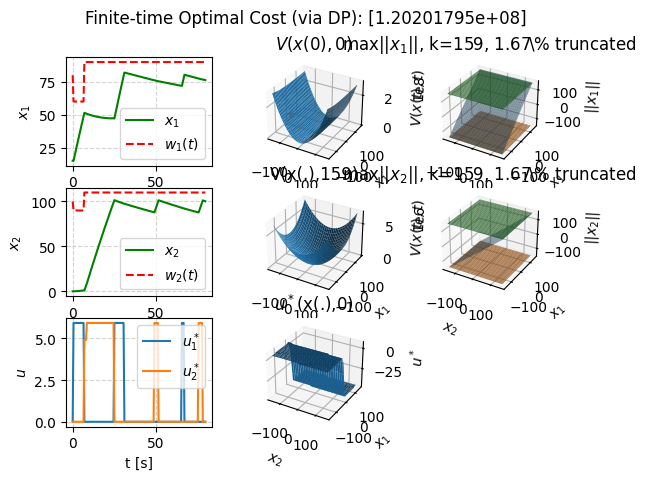

In [16]:
pt.close()
fig, ax = pt.subplots(3,3)

# Simulation (from z0 using u_opt(x)) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
z = np.zeros((T.size, 2))
z[0, :] = z0
u1 = np.zeros((T.size, 1))
u2 = np.zeros((T.size, 1))


w_hist = np.zeros((T.size, 2))
w_hist[0, :] = w_cur

for k in range(0, T.size-1):

    prev_state = state
    u_opt_sw, u_opt2_sw, V_sw, V2_sw = tables[sw]

    # admissibility check must be on ERROR (because the DP grid is on ERROR)
    e = z[k, :] - w_cur
    if not(e[0] >= x1[0, 0] and e[0] <= x1[0, -1]
           and e[1] >= x2[0, 0] and e[1] <= x2[-1, 0]):
        print(f'stopped at {k}/{T.size}', z[k,0], z[k,1])
        break

    if state == 0:
        # no heating
        u1[k] = 0.0
        u2[k] = 0.0
        z[k+1, :] = z[k, :] + (A @ z[k, :]) * dt

        # activation logic
        if z[k+1, 0] <= alpha * w_cur[0]:
            state = 1
        elif z[k+1, 1] <= alpha * w_cur[1]:
            state = 2

    elif state == 1:
        # heater 1 active: use tabular law u_opt (finite-horizon => use time index k)
        u1[k] = u_opt_sw[lookup(x2[:, 0], e[1]), lookup(x1[0, :], e[0]), k]
        u2[k] = 0.0

        z[k+1, :] = z[k, :] + (A @ z[k, :] + np.array([float(u1[k]), 0.0])) * dt

        # switching logic
        if (z[k+1, 0] >= w_cur[0] - t1 and z[k+1, 1] <= alpha * w_cur[1]) or (z[k+1, 1] <= 0 and z[k+1, 0] >= 20):
            state = 2
        elif z[k+1, 0] >= w_cur[0] - t1:
            state = 0

    elif state == 2:
        # heater 2 active: use tabular law u_opt2 (finite-horizon => use time index k)
        u2[k] = u_opt2_sw[lookup(x2[:, 0], e[1]), lookup(x1[0, :], e[0]), k]
        u1[k] = 0.0

        z[k+1, :] = z[k, :] + (A @ z[k, :] + np.array([0.0, float(u2[k])])) * dt

        # switching logic
        if (z[k+1, 1] >= w_cur[1] - t2 and z[k+1, 0] <= alpha * w_cur[0]) or (z[k+1, 0] <= 0 and z[k+1, 1] >= 20):
            state = 1
        elif z[k+1, 1] >= w_cur[1] - t2:
            state = 0
    
    if state != prev_state:
        sw = min(sw + 1, T_sw - 1)
        w_cur = w_seq[sw]

    w_hist[k+1, :] = w_cur



# Visualisation %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
u_opt0, u_opt20, V0, V20 = tables[0]
w0 = w_seq[0]
Vz0 = V0[lookup(x2[:,0], z0[1]-w0[1]), lookup(x1[0,:], z0[0]-w0[0]), 0]
inval_x1 = 100 * np.where(np.logical_or(err_x1[:, :] > x1[1, -1], err_x1[:, :] < x1[1, 1]))[0].size \
    / (x1[:, 1].size * x2[1, :].size)
inval_x2 = 100 * np.where(np.logical_or(err_x2[:, :] > x2[-1, 1], err_x2[:, :] < x2[1, 1]))[0].size \
    / (x1[:, 1].size * x2[1, :].size)

ax[0,0].plot(T, z[:,0], 'g-', label=r'$x_1$')
ax[0,0].set(xlabel=r't [s]', ylabel=r'$x_1$')
ax[0,0].plot(T, w_hist[:,0], 'r--', label=r'$w_1(t)$')
ax[1,0].plot(T, z[:,1], 'g-', label=r'$x_2$')
ax[1,0].set(xlabel=r't [s]', ylabel=r'$x_2$')
ax[1,0].plot(T, w_hist[:,1], 'r--', label=r'$w_2(t)$')
ax[2,0].plot(T, u1, label=r'$u_1^*$')
ax[2,0].plot(T, u2, label=r'$u_2^*$')
ax[2,0].set(xlabel=r't [s]', ylabel=r'$u$')
ax[2,0].legend()

ax1 = fig.add_subplot(3,3,2, projection='3d')
ax1.plot_surface(x2, x1, V0[:,:,1])
ax1.set(xlabel=r'$x_2$', ylabel=r'$x_1$', zlabel=r'$V(x(t),t)$', title=f'$V(x({depth}),{depth})$')
ax1.plot(z0[1]-w0[1], z0[0]-w0[0], Vz0, marker='*')

kp = N-1
ax2 = fig.add_subplot(3,3,5, projection='3d')
ax2.plot_surface(x2, x1, V0[:,:,kp])
ax2.set(xlabel=r'$x_2$', ylabel=r'$x_1$', zlabel=r'$V(x(t),t)$', title=f'V(x(.),{kp})')

ax3 = fig.add_subplot(3,3,8, projection='3d')
ax3.plot_surface(x2, x1, u_opt0[:,:,depth])
ax3.set(xlabel=r'$x_2$', ylabel=r'$x_1$', zlabel=r'$u^*$', title=f'$u^*$(x(.),{depth})')

ax4 = fig.add_subplot(3,3,3, projection='3d')
ax4.plot_surface(x2, x1, err_x1, alpha=.5, label=r'$||x_1||$')
ax4.set(xlabel=r'$x_2$', ylabel=r'$x_1$', zlabel=r'$||x_1||$',
        title=f'$\max||x_1||$, k={kp}, {inval_x1:.2f}\% truncated')
ax4.plot_surface(x2, x1, np.ones((x2.shape[0], x1.shape[1]))*x1[1,1], alpha=.7)
ax4.plot_surface(x2, x1, np.ones((x2.shape[0], x1.shape[1]))*x1[-1,-1], alpha=.7)

ax5 = fig.add_subplot(3,3,6, projection='3d') # frameon=False
ax5.plot_surface(x2, x1, err_x2, alpha=.5, label=r'$||x_2||$')
ax5.set(xlabel=r'$x_2$', ylabel=r'$x_1$', zlabel=r'$||x_2||$',
        title=f'$\max||x_2||$, k={kp}, {inval_x2:.2f}\% truncated')
ax5.plot_surface(x2, x1, np.ones((x2.shape[0], x1.shape[1]))*x2[1,1], alpha=.7)
ax5.plot_surface(x2, x1, np.ones((x2.shape[0], x1.shape[1]))*x2[-1,-1], alpha=.7)

for i in range(ax.shape[0]):
    ax[i,0].grid(color='lightgray', linestyle='--')
    ax[i,0].legend()
    ax[i,1].axis('off')
    ax[i,2].axis('off')
fig.suptitle(f'Finite-time Optimal Cost (via DP): {Vz0}')
fig.show()


The main additions and modifications in the original code are described below.

### 1. Completion of the Settings Block

Concrete numerical values were assigned to all parameters:
- time discretisation `dt` and horizon `T`,
- admissible control set `U`,
- discretised state grid `x1, x2`,
- cost matrices `Q` and `R`,
- initial state `z0` and reference (set-point) `w`.

This fully specifies the finite-horizon DP problem and defines the discrete state–control domain over which the value function is computed.  
The penalty `infStValInc` is used to discourage transitions that leave the admissible state grid during forward Euler propagation.

---

### 2. Introduction of a Second Tabular Controller (H5.2(b))

To satisfy the requirement of two independent SISO controllers, the DP data structures were duplicated:
- `V` and `u_opt` correspond to **mode ℓ₁** (heater 1 active),
- `V2` and `u_opt2` correspond to **mode ℓ₂** (heater 2 active).

Each controller is computed independently using the same DP algorithm but with different input channels. This allows each tank to be regulated by its own optimal tabular law when the corresponding heater is active.

---

### 3. Completion of the DP Algorithm (Value Iteration)

The dynamic programming loop was completed as follows:

- **Stage cost**  
  A quadratic running cost was implemented:
  $$
  \ell(x,u) = x^\top Q x + u^\top R u,
  $$
  evaluated for all admissible control inputs.

- **System propagation**  
  Forward Euler discretisation is used to approximate the dynamics.  
  For mode ℓ₁, the control affects only the first state component; for mode ℓ₂, only the second component is actuated.

- **Bellman update**  
  At each grid point and time step, the optimal control is selected by minimising the sum of the stage cost and the cost-to-go.  
  The corresponding optimal value and control are stored in `V` / `u_opt` and `V2` / `u_opt2`.

- **Out-of-domain handling**  
  Transitions leaving the discretised state space are penalised using `infStValInc`. Diagnostic arrays (`err_x1`, `err_x2`) track truncation.

This completes the value iteration procedure required in H5.2(a).

---

### 4. Hybrid Simulation and Jump Logic (H5.2(c))

The simulation part was extended to implement the hybrid automaton required by the exercise.

- **Separate control signals**  
  Two control signals `u1` and `u2` are used to clearly distinguish which heater is active.

- **Hybrid modes**  
  A discrete variable `state ∈ {0,1,2}` represents:
  - `0`: both heaters off,
  - `1`: heater 1 active (mode ℓ₁),
  - `2`: heater 2 active (mode ℓ₂).

- **Mode-dependent control and dynamics**  
  In each mode, the corresponding tabular controller (`u_opt` or `u_opt2`) is applied and the system dynamics are updated accordingly.

- **Jump (guard) conditions**  
  Switching between modes is governed by tolerance-based guards:
  - when a tank is sufficiently close to its set-point,
  - and the other tank is sufficiently below its reference.  

  This implements the hybrid switching mechanism requested in H5.2(c).

---

### 5. Visualisation Updates

The plotting section was adapted to:
- display both control inputs `u_1^*` and `u_2^*`,
- visualise the value function and optimal control surfaces,
- report truncation statistics for the DP grid.

---

## Interpretation of the Results

The simulation results exhibit the expected behaviour :

- **State trajectories**  
  Both tank temperatures move toward their respective set-points but do not converge smoothly. Small oscillations appear due to:
  - discrete control actions,
  - nearest-neighbour interpolation on the DP grid,
  - and the fact that only one heater is active at a time.

- **Control signals**  
  The control inputs are piecewise constant and alternate between heaters. This reflects:
  - the tabular nature of the DP policy,
  - and hybrid switching between modes ℓ₁ and ℓ₂.
